In [9]:
import yfinance as yf
import pandas as pd

# Fetch historical stock price data
ticker = 'AAPL'  # Apple Inc.
stock_data = yf.download(ticker, start='2020-01-01', end='2024-01-01')

# Display the first few rows
print(stock_data.head())


[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2020-01-02  72.716087  72.776613  71.466827  71.721034  135480400
2020-01-03  72.009109  72.771737  71.783954  71.941321  146322800
2020-01-06  72.582924  72.621661  70.876090  71.127881  118387200
2020-01-07  72.241562  72.849239  72.021246  72.592609  108872000
2020-01-08  73.403641  73.706271  71.943751  71.943751  132079200


In [10]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Selecting only the 'Close' price column
df = stock_data[['Close']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

print(scaled_data[:5])  # First 5 normalized values


[[0.12820382]
 [0.1232418 ]
 [0.12726919]
 [0.1248733 ]
 [0.13302951]]


In [11]:
def create_sequences(data, seq_length=60):
    X, Y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        Y.append(data[i+seq_length])
    return np.array(X), np.array(Y)

# Set sequence length (past 60 days of data to predict next day)
sequence_length = 60
X, Y = create_sequences(scaled_data, sequence_length)

# Splitting into train and test sets
split_ratio = 0.8
split = int(len(X) * split_ratio)

X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]

print(f"Training Samples: {X_train.shape}, Testing Samples: {X_test.shape}")


Training Samples: (756, 60, 1), Testing Samples: (190, 60, 1)


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test))


Epoch 1/50


d:\python-coding-challenge\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.0968 - val_loss: 0.0049
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0102 - val_loss: 0.0039
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0069 - val_loss: 0.0063
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0052 - val_loss: 0.0035
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0044 - val_loss: 0.0051
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0041 - val_loss: 0.0062
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0036 - val_loss: 0.0058
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0039 - val_loss: 0.0043
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0034 - val_l

In [13]:
# Predict on test data
predicted_prices = model.predict(X_test)

# Inverse transform predictions to actual price scale
predicted_prices = scaler.inverse_transform(predicted_prices)
actual_prices = scaler.inverse_transform(Y_test.reshape(-1, 1))


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step


In [14]:
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print(f"RMSE: {rmse:.2f}")


RMSE: 7.31


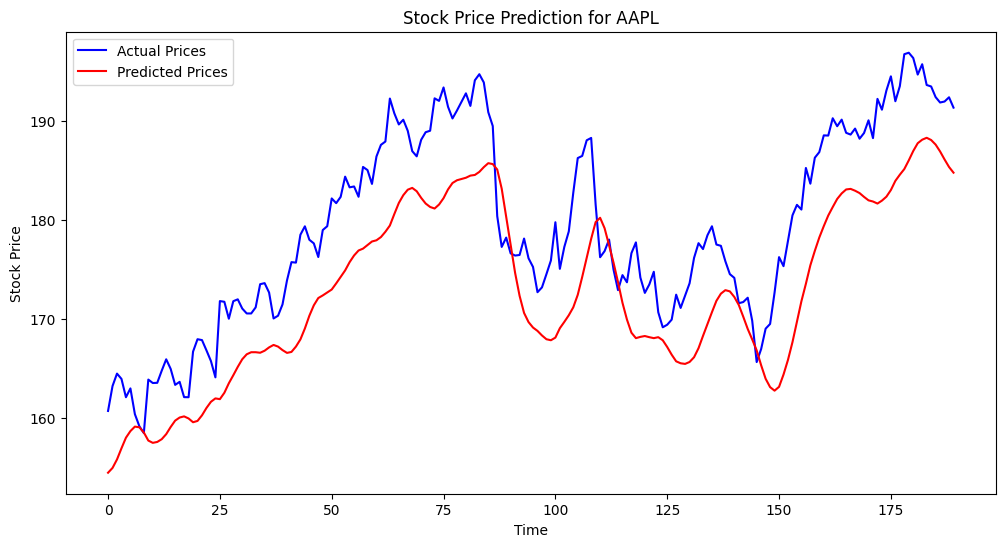

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Prices', color='blue')
plt.plot(predicted_prices, label='Predicted Prices', color='red')
plt.title(f"Stock Price Prediction for {ticker}")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()
